## Week 19 : Serverless Deployment & Cloud Security

### Cloud Security: IAM and Firewalls

#### Identity and Access Management (IAM)
IAM is the system that manages who can do what on which resources.

- Roles and Policies: You don't grant direct access; instead, you create policies (JSON documents) that define permissions (e.g., s3:GetObject on a specific bucket). You then assign these policies to a user, group, or role.

- The Least-Privilege Principle
    - This principle states that a user, service account, or resource should only be granted the minimum permissions necessary to perform its intended job—no more, no less.
    - Example: If your serverless function only needs to read a file from a storage bucket to run your AI model, its associated IAM role should only have storage:read permission on that specific bucket, and nothing else (no write, delete, or access to other resources). This minimizes the potential damage if the function or its credentials are ever compromised.


#### Cloud Firewalls and Security Groups

These tools control network traffic, acting as a virtual barrier to protect your cloud resources.
 - Cloud Firewalls (Network-Level): These operate at the Virtual Private Cloud (VPC) level and control traffic flowing in and out of your entire network. They are generally used for broad, network-wide rules.
 - Security Groups (Resource-Level): These act as a virtual firewall for a specific resource, such as a serverless function, Virtual Machine (VM), or database.
    - They are stateful: if a request is allowed in, the response is automatically allowed out.
    - They define rules based on Protocol (TCP, UDP), Port (e.g., 80 for HTTP, 443 for HTTPS), and Source/Destination IP addresses.
    - For your serverless deployment: You will likely use a Security Group to ensure only the necessary ports are open to the internet, or to restrict inbound traffic to your API Gateway.


---


# Exercise

### Lambda Function
1. Search for Lambda: Log into your AWS Console and type Lambda in the search bar.
2. Create Function: Click the orange Create function button.
3. Basic Info:
    - Keep Author from scratch selected.
    - Function name: MyFirstServerlessAI.
    - Runtime: Choose Python 3.12 (the most recent stable version).
    - Architecture: Keep it on x86_64.
4. Create: Scroll down and click Create function.
5. The Code: Once it loads, scroll down to the Code tab. You'll see a default script. Replace it with this to make it feel more "AI-ready":

    ```python 
    import json

    def lambda_handler(event, context):
        return {
            'statusCode': 200,
            'body': json.dumps('Serverless AI Environment: Initialized and Active!')
        }
    ```
6. Deploy & Test: Click Deploy (the small button above the code editor). Then click Test.
    - First-time setup: Give your test event a name like Test1 and just hit Save.
    - Click Test again. You should see a green "Execution result: succeeded" box.

    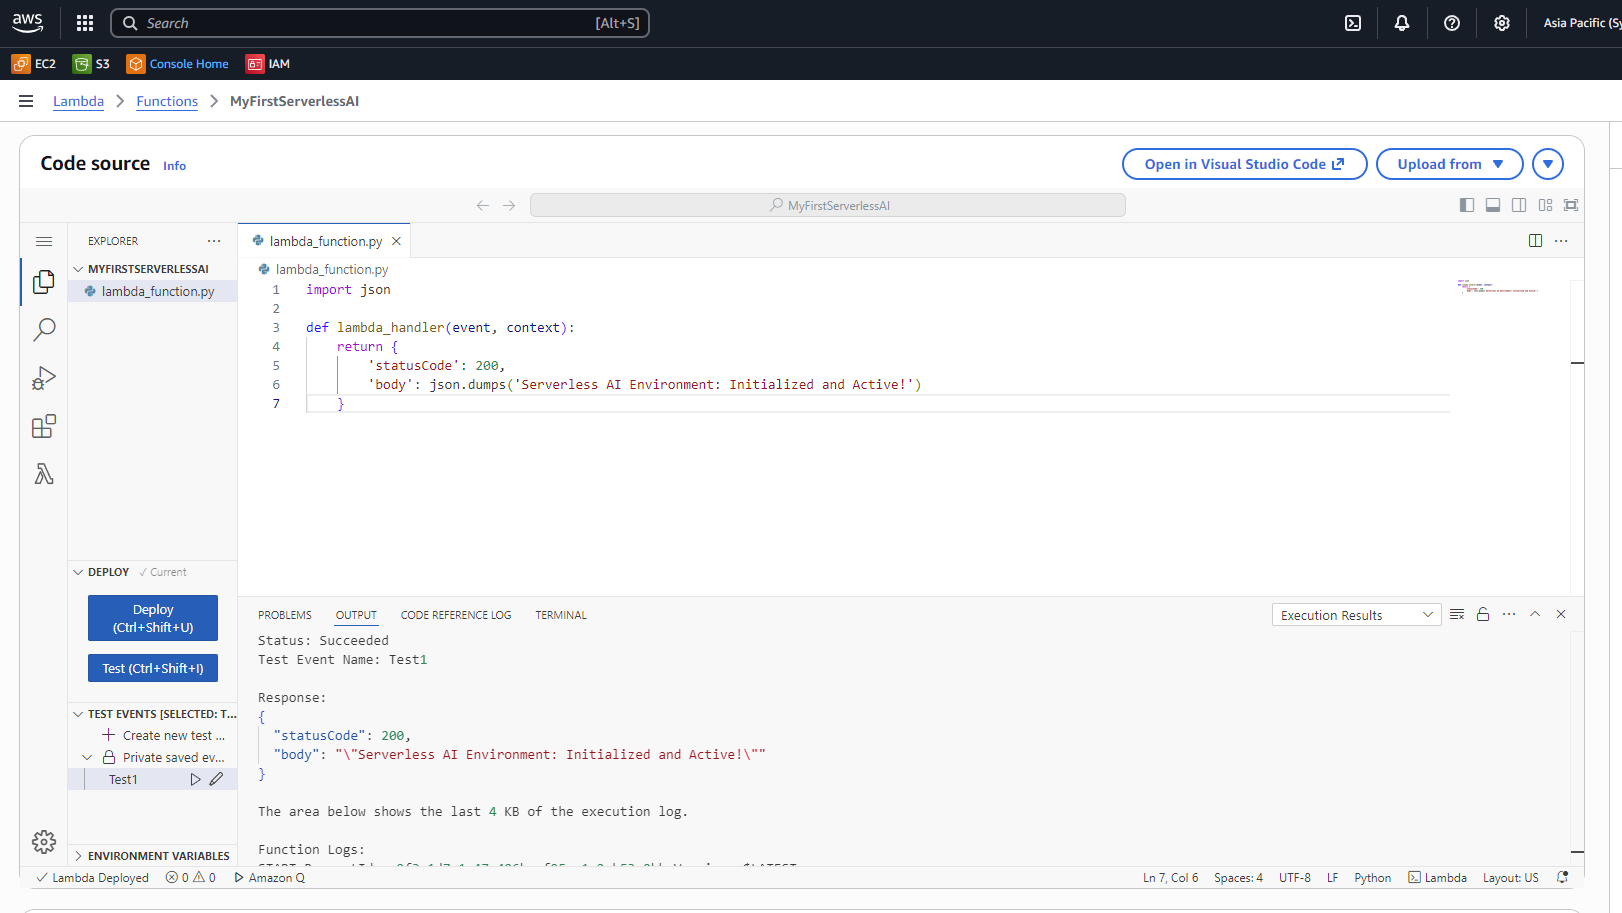

### IAM Least Privilege Test

1. Create the restricted user
    1. Search for IAM in the AWS Console.
    2. On the left sidebar, click Users, then click the orange Create user button.
    3. Step 1 (Specify user details):
        - User name: SecurityTester
        - Check the box: Provide user access to the AWS Management Console.
        - Select I want to create an IAM user (this is usually the second option).
        - Console password: Choose Custom password and type one in. `Week19Test`
        - Uncheck "Users must create a new password at next sign-in" (to keep this test quick).

    4. Step 2 (Set permissions):
        - Select Attach policies directly.
        - In the search box, type AWSLambda_ReadOnlyAccess.
        - Check the box next to that policy.
        - Theory Check: This policy allows the user to see lists of functions and read their code, but it has zero "Write" or "Delete" permissions.

    5. Step 3 (Review and create): Click Next, then click Create user.

    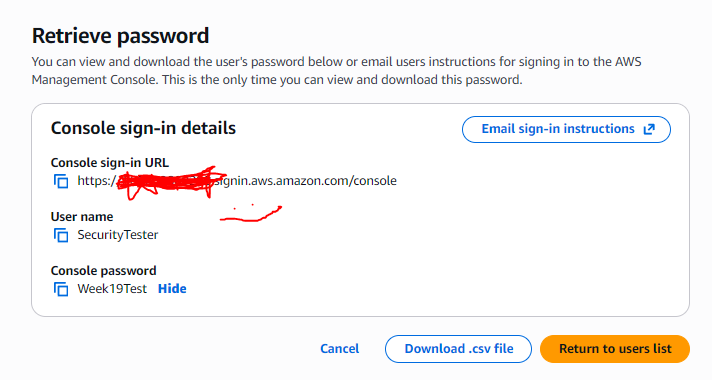

    Next login, password will be `Week19TestChangedPass`

2. The Access Denied Test
    1. Copy the Console Sign-in URL: On the final success screen (or on the IAM Dashboard), look for the "Console sign-in URL." It looks like https://123456789012.signin.aws.amazon.com/console.
    2. Login as the Restricted User: Open a Private/Incognito window and go to that URL. Log in as SecurityTester.
    3. Navigate to Lambda: Search for Lambda and find the "Hello World" function you created earlier.
    4. Try to Delete: * Select the function.
        - Click Actions -> Delete.
        - Confirm the deletion.
    5. The Result: You should see a red error banner at the top of the screen saying "You are not authorized to perform: lambda:DeleteFunction".

    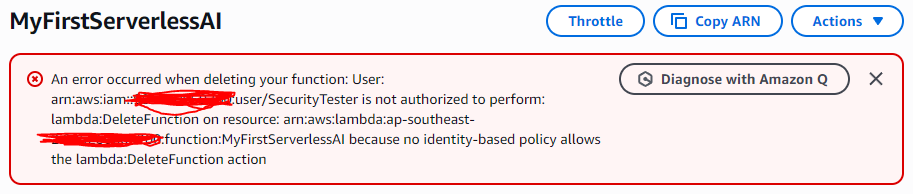

---

### Deploy AI Model as Serverless Function

1. Prepare your Model File:
    - Locate your trained model file (likely named model.pkl or model.joblib) from your Week 13 project.
    - If the file is larger than 50MB, you should upload it to an S3 bucket and have your Lambda function download it on startup. If it is small, you can package it directly with your code.
2. Write the Lambda Handler (lambda_function.py): Replace your "Hello World" code with a script that loads the model and makes a prediction. Here is a standard template:

    ```python
    import json
    import joblib  # or import pickle
    import numpy as np

    # Load the model once when the 'container' starts (warm start)
    # Ensure 'model.joblib' is the exact name of your uploaded file
    model = joblib.load('model.joblib') 

    def lambda_handler(event, context):
        try:
            # 1. Parse the incoming data (features)
            # We expect a JSON like: {"features": [5.1, 3.5, 1.4, 0.2]}
            body = json.loads(event['body'])
            input_data = np.array(body['features']).reshape(1, -1)
            
            # 2. Make the prediction
            prediction = model.predict(input_data)
            
            # 3. Return the numerical result
            return {
                'statusCode': 200,
                'body': json.dumps({
                    'prediction': int(prediction[0]),
                    'status': 'success'
                })
            }
        except Exception as e:
            return {
                'statusCode': 400,
                'body': json.dumps({'error': str(e)})
            }
    ```

3. Add the Required Libraries (The "Layer")
- Standard AWS Lambda does not have numpy or scikit-learn installed. If you try to run the code above now, it will crash with an ImportError.
    - In your Lambda console, scroll down to the Layers section.
    - Click Add a layer.
    - Choose AWS Layers.
    - Select AWSSDKPandas-Python3x (this is a pre-built bundle that includes NumPy and Pandas).
        - Note: If you specifically need Scikit-learn, you may need to add a custom ARN for a Scikit-learn layer (common in the ML community).

4. Test the Live Endpoint
    - To prove this is a "deployment" and not just a script:
        - Go to the Test tab in Lambda.
        - Create a new test event with a JSON body representing your model's input (e.g., {"body": "{\"features\": [1, 2, 3, 4]}"}).
        - Click Test.

Portfolio Task: Take a screenshot of the "Execution Result" showing a successful prediction (e.g., prediction: 1). This is the "Live Test" required for your documentation.

Note: having issues with AWS for deployment - free tier thingy



---